# Tomography tomorec example notebook
This notebook is an example to be used with the "Tomography / Tomorec / GPU" kernel.

### Most Recent Update
2020-04-29 11:00 - Jason <br>
Copied what is in https://github.com/tomograms/tomography-notebooks/blob/rajmund/tomorec_lungs.ipynb

## Import modules

In [1]:
%env MKL_NUM_THREADS 1
%env OMP_NUM_THREADS 1
ncore = 8

env: MKL_NUM_THREADS=1
env: OMP_NUM_THREADS=1


In [2]:
import tomopy
import dxchange
import matplotlib.pyplot as plt
import h5py
import time
import tifffile
import numpy as np

## Set the path to the micro-CT data to reconstruct.

In [3]:
fp = h5py.File('/mxn/groups/kits/scisw/jupyterhub/data-for-validations/tomography/tomorec/VILI_mouse_5_pm2_e.h5','r')
ff = h5py.File('/mxn/groups/kits/scisw/jupyterhub/data-for-validations/tomography/tomorec/VILI_mouse_5_pm2_refs.h5','r')

In [4]:
proj = fp['exchange/data']
flat = ff['exchange/data_white']
dark = ff['exchange/data_dark']
print(proj.shape, flat.shape, dark.shape)

(901, 1048, 2016) (100, 1048, 2016) (30, 1048, 2016)


## If the angular information is not available from the raw data you need to set the data collection angles. In this case theta is set as equally spaced between 0-180 degrees.

In [5]:
theta = tomopy.angles(proj.shape[0])

## Perform the flat-field correction of raw data: $$ \frac{proj - dark} {flat - dark} $$

In [6]:
proj = tomopy.normalize(proj, flat, dark)
print(proj.shape)

(901, 1048, 2016)


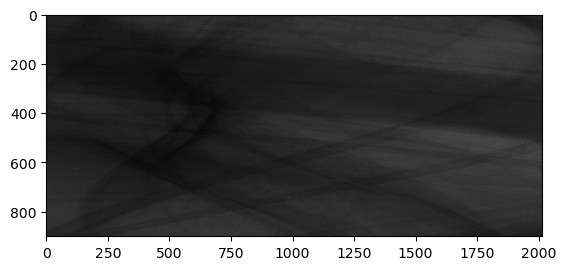

In [7]:
plt.imshow(proj[:,40, :], cmap='Greys_r')
plt.show()

## Tomopy provides various methods to [find rotation center](http://tomopy.readthedocs.io/en/latest/api/tomopy.recon.rotation.html).

In [8]:
rot_center = tomopy.find_center(proj, theta, init=1008, ind=0, tol=0.5)
print(rot_center)

Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
[1002.4875

In [9]:
proj = tomopy.prep.phase.retrieve_phase(proj, pixel_size=0.0003, dist=10, energy=22, alpha=0.00020, pad=True, ncore=ncore)

## Reconstruction using Gridrec algorithm.Tomopy provides various [reconstruction](http://tomopy.readthedocs.io/en/latest/api/tomopy.recon.algorithm.html) methods including the one part of the [ASTRA toolbox](https://sourceforge.net/p/astra-toolbox/wiki/Home/).

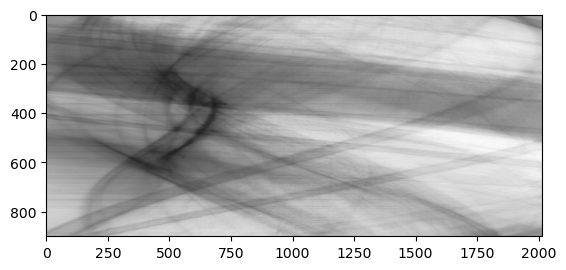

In [10]:
plt.imshow(proj[:, 40,:], cmap='Greys_r')
plt.show()

## Calculate $$ -log(proj) $$

In [11]:
proj = tomopy.minus_log(proj, ncore=ncore)

## Padding to remove the gradient around the FOV in the reconstruction

In [12]:
N = proj.shape[2]
proj_pad = np.zeros([proj.shape[0],proj.shape[1],3*N//2],dtype = "float32")
proj_pad[:,:,N//4:5*N//4] = proj
proj_pad[:,:,0:N//4] = np.tile(np.reshape(proj[:,:,0],[proj.shape[0],proj.shape[1],1]),(1,1,N//4))
proj_pad[:,:,5*N//4:] = np.tile(np.reshape(proj[:,:,-1],[proj.shape[0],proj.shape[1],1]),(1,1,N//4))

proj = proj_pad
rot_center = rot_center+N//4

## Select / define tomo algorithms

In [13]:
algorithm = 'gridrec'

In [14]:
slice_first=500
slice_last=501
aproj=proj[:,slice_first:slice_last,:]
print(aproj.shape)

(901, 1, 3024)


In [15]:
recon = tomopy.recon(aproj, theta, center=rot_center, algorithm=algorithm, filter_name='parzen')
recon = recon[:,N//4:5*N//4,N//4:5*N//4]
        
print("Algorithm: ", algorithm)

Reconstructing 1 slice groups with 1 master threads...
Algorithm:  gridrec


In [16]:
print(recon.shape)

(1, 2016, 2016)


## Mask each reconstructed slice with a circle.

In [17]:
recon = tomopy.circ_mask(recon, axis=0, ratio=0.95, ncore=ncore)

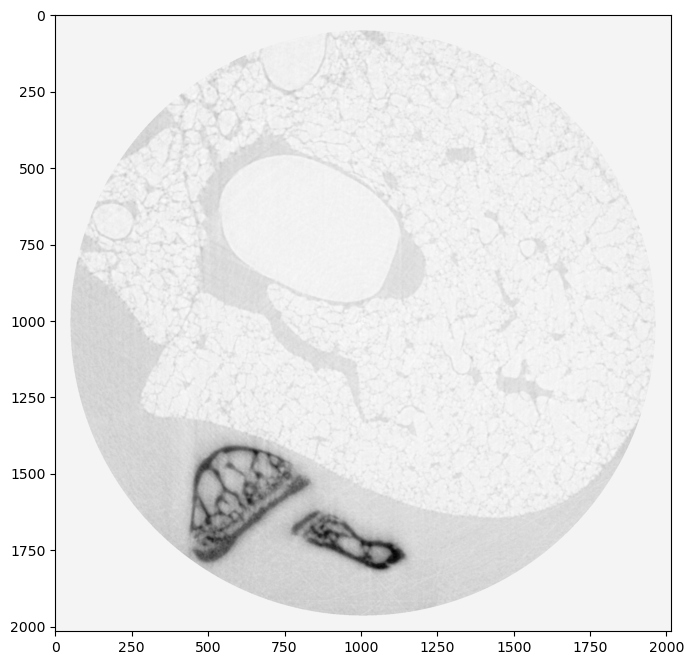

In [18]:
fig = plt.figure(figsize=(9,8))
plt.imshow(recon[0, :,:], cmap='Greys')
plt.show()

### Save as tiff file

In [19]:
from PIL import Image
from io import BytesIO

png1 = BytesIO()
fig.savefig(png1, format='png')
png2 = Image.open(png1)
png2.save('/mxn/groups/kits/scisw/jupyterhub/data-for-validations/tomography/tomorec/output/gridrec_alpha15e-5.tiff')